In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding,Dot, Dense, Flatten ,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
from wordcloud import WordCloud
import math 
%matplotlib inline 


### READING ANIMELIST.CSV

In [2]:
import os 

In [3]:
INPUT_DIR = os.path.join("..", "artifacts","raw")

In [4]:
INPUT_DIR

'../artifacts/raw'

In [5]:
rating_df = pd.read_csv(os.path.join(INPUT_DIR, "animelist.csv"), low_memory=True,
                        usecols=['user_id','anime_id','rating'])

In [6]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [7]:
len(rating_df)

5000000

### DATA PROCESSING

In [8]:
n_ratings = rating_df['user_id'].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >=400].index)].copy()
len(rating_df)

3246641

In [9]:
min_rating = min(rating_df['rating'])
min_rating

0

In [10]:
max_rating = max(rating_df['rating'])
max_rating

10

In [11]:
avg_rating = np.mean(rating_df['rating'])
avg_rating

np.float64(4.122732695114736)

In [12]:
rating_df['rating'] = rating_df['rating'].apply(lambda x:(x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)



In [13]:
# Check new average
new_avg = np.mean(rating_df['rating'])
print(f"New scaled average rating: {new_avg}")

New scaled average rating: 0.4122732695114729


In [14]:
new_max_rating = max(rating_df['rating'])
new_max_rating

1.0

In [15]:
new_min_rating = min(rating_df['rating'])
new_min_rating

0.0

In [16]:
rating_df.duplicated().sum()

np.int64(0)

In [17]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [18]:
user_ids =rating_df['user_id'].unique().tolist()
user2user_encoded ={x: i for i,x in enumerate(user_ids)}
dict(list(user2user_encoded.items())[:5])
user2user_decoded ={i: x for i,x in enumerate(user_ids)}
dict(list(user2user_decoded.items())[:5])

{0: 2, 1: 6, 2: 12, 3: 16, 4: 17}

In [19]:
rating_df['user']= rating_df['user_id'].map(user2user_encoded)
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [20]:
n_users = len(user2user_encoded)
n_users

4203

In [21]:
anime_ids =rating_df['anime_id'].unique().tolist()
anime2anime_encoded ={x: i for i,x in enumerate(anime_ids)}
anime2anime_decoded ={i: x for i,x in enumerate(anime_ids)}
rating_df['anime']= rating_df['anime_id'].map(anime2anime_encoded)


In [22]:
rating_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


In [23]:
n_anime = len(anime2anime_encoded)
n_anime

17149

In [24]:
rating_df = rating_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [25]:
X= rating_df[['user', 'anime']].values
y = rating_df['rating'].values


In [26]:
test_size = 1000
train_indices = rating_df.shape[0]-test_size
X_train, X_test, y_train, y_test = X[:train_indices], X[train_indices:], y[:train_indices], y[train_indices:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3245641, 2), (1000, 2), (3245641,), (1000,))

In [27]:
type(X_train), type(X_test), type(y_train), type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [28]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [29]:
type(X_test_array), type(X_train_array)

(list, list)

In [30]:
type(X_test_array[0]), type(X_train_array[0]), type(X_test_array[1]), type(X_train_array[1])

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

### Model Architecture 

In [40]:
# Initial Fixed Learning Rate for Adam
initial_learning_rate = 0.001 # A much more standard starting point for Adam

batch_size    = 4096   # Reduced batch size
epochs        = 50     # Increased epochs, EarlyStopping will manage duration
embedding_size = 128
dropout_rate = 0.25  # Reduced dropout rate


In [41]:
# --- Model Definition (Revised) ---
def RecommenderNet(n_users, n_anime, embedding_size=128, dropout_rate=0.25):
    """Defines the Recommender Model architecture with Batch Norm."""

    # inputs
    user_in  = Input(name='user',  shape=(1,))
    anime_in = Input(name='anime', shape=(1,))

    # embeddings
    # Consider adding regularization later if overfitting: embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    uemb = Embedding(input_dim=n_users, output_dim=embedding_size, name='user_emb')(user_in)
    aemb = Embedding(input_dim=n_anime, output_dim=embedding_size, name='anime_emb')(anime_in)

    # flatten
    uflat = Flatten()(uemb)
    aflat = Flatten()(aemb)

    # similarity + MLP head
    x = Dot(axes=1, normalize=True, name='dot')([uflat, aflat]) # Cosine similarity

    # Dense Head with Batch Normalization and reduced Dropout
    x = Dense(64, activation=None, kernel_initializer='he_normal', name='hidden')(x) # No activation before BN
    x = BatchNormalization()(x) # Add Batch Norm
    x = Activation('relu')(x)   # Activation after BN
    x = Dropout(dropout_rate)(x) # Use the parameter
    out = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=[user_in, anime_in], outputs=out)

    # Compile with the revised fixed learning rate
    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(
      optimizer=optimizer,
      loss='binary_crossentropy',
      metrics=['accuracy', tf.keras.metrics.AUC(name='auc')] # AUC is good for ranking
    )
    return model

In [42]:
# build & train
model = RecommenderNet(n_users=n_users, n_anime=n_anime)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_emb            │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_emb           │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 128)       │          0 │ user_emb[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 128)       │          0 │ anime_emb[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden (Dense)      │ (None, 64)        │        128 │ dot[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ hidden[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,505 (10.43 MB)

 Trainable params: 2,733,377 (10.43 MB)

 Non-trainable params: 128 (512.00 B)

In [45]:
checkpoint_filepath = "best_recommender_weights.weights.h5" # Use .h5 extension
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_auc',         # Monitor validation AUC
    mode='max',                # Maximize AUC
    save_best_only=True,       # Save only the best weights
    save_weights_only=True,    # Save only weights
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_auc',         # Monitor validation AUC
    mode='max',                # Maximize AUC
    patience=10,               # Increased patience
    restore_best_weights=True, # Restore weights from the best epoch
    verbose=1
)

# Optional: Reduce LR if val_auc plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.2,          # Reduce LR by factor of 5
    patience=5,          # Reduce after 5 epochs of no improvement
    min_lr=1e-6,         # Minimum learning rate
    mode='max',
    verbose=1
)


In [46]:
my_callbacks = [
    model_checkpoint,
    early_stopping,
    reduce_lr]


In [47]:
print("Starting training...")
history = model.fit(
    [X_train_array[0], X_train_array[1]],
    y_train,
    batch_size=batch_size,
    epochs=epochs, # Max epochs, early stopping will likely stop sooner
    verbose=1,
    validation_data=([X_test_array[0], X_test_array[1]], y_test),
    callbacks=my_callbacks
)
print("Training finished.")

Starting training...
Epoch 1/50
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3925 - auc: 0.5002 - loss: 0.6946
Epoch 1: val_auc improved from -inf to 0.50375, saving model to best_recommender_weights.weights.h5
793/793 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.3925 - auc: 0.5002 - loss: 0.6946 - val_accuracy: 0.4510 - val_auc: 0.5037 - val_loss: 0.6732 - learning_rate: 0.0010
Epoch 2/50
792/793 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4332 - auc: 0.5532 - loss: 0.6750
Epoch 2: val_auc improved from 0.50375 to 0.55155, saving model to best_recommender_weights.weights.h5
793/793 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.4332 - auc: 0.5532 - loss: 0.6750 - val_accuracy: 0.4510 - val_auc: 0.5516 - val_loss: 0.6706 - learning_rate: 0.0010
Epoch 3/50
793/793 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3668 - auc: 0.6926 - loss: 0.6337
Epoch 3: val_auc improved from 0.55155 to 0.67262, saving model to best_recommender_weights.weights.h5
793/793 ━━━━━━━━━━━━

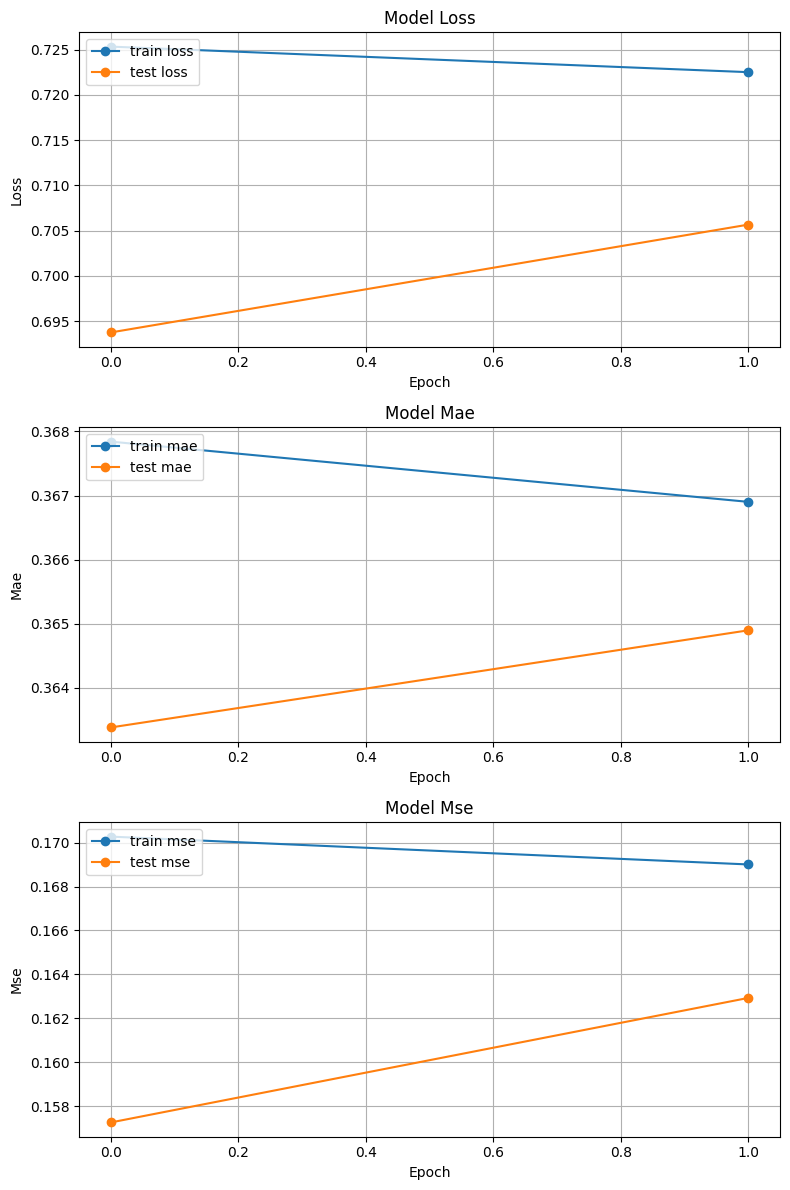

In [ ]:
metrics = ["loss", "mae", "mse"]    

fig, axes = plt.subplots(len(metrics), 1, figsize =(8, len(metrics)*4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker='o',label = f"train {metric}")
    ax.plot(history.history['val_'+metric][0:-2], marker='o',label = f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc='upper left')
    ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)